## Numerically simulating the Ising model

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from GenerateIsing import *
import pickle
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (12,8)


### Metropolis Algorithm

We consider the Ising model, with Hamiltonian $-\beta\mathcal{H} = K\sum_{\langle i,j\rangle} \sigma_i\sigma_j$ on a $d$-dimensional hypercubic lattice, with the spins $\sigma_i$ assuming values $\pm 1$. Lets first define such a lattice of dimension $d$ with side lengths $N$. We will implement the Metropolis algorithm, s.t. we begin by randomly initializing a spin configuration, and perform a set of $M$ "iterations". Each iteration is composed of flipping a single randomly selected spin, computing the change in energy $\Delta$ and if $\Delta<0$ we update the spins accordingly, otherwise we accept with probability $\exp(-\Delta)$. We will analyze the behaviour of the systems magnetization as a function of $K$. Note that we expect a second order phase transition in the magnetization which varies with $K$ as $m = (1-\sinh^{-4}(2K))^{1/8}$, so with $K<K_c = \frac{1}{2}\ln(1+\sqrt{2})\approx 0.44$ this is $0$ otherwise it is not and tends towards 1. We will verify as much in the simulations below. First, however, let us generate a grid for a $K<K_c$ and plot a colourmesh of the system.

In [133]:
d = 2
N = 25
M = 2*(N**d)*100#This N^2 scaling is apparently needed
K = 0.01

grid = lattice(d,N)

grid = metropolis(grid,N,d,M,K)

<ipython-input-134-d9350d04a04c>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, grid, cmap='RdGy');


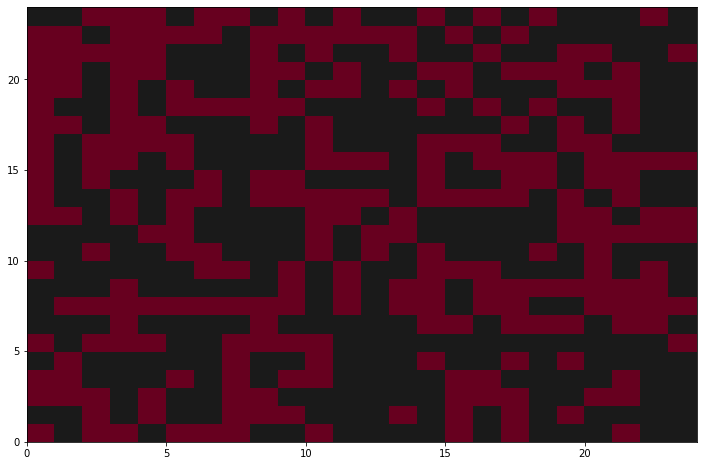

Note the magnetization near 0: 0.0592


In [134]:
X, Y = np.meshgrid(range(N), range(N))
plt.pcolormesh(X, Y, grid, cmap='RdGy');

plt.show()
print ("Note the magnetization near 0: " + str(np.abs(np.mean(grid))))

Now, we find the magnetization by averaging over time and repeated trial simulations as below.

In [138]:
N = 15
M = (N**2)*500

dK = 0.015
steps = 20
K_low = 0.25
iters = 2

K_vals,mags,stds = sweep(N,d,M,K_low,dK,steps,iters)

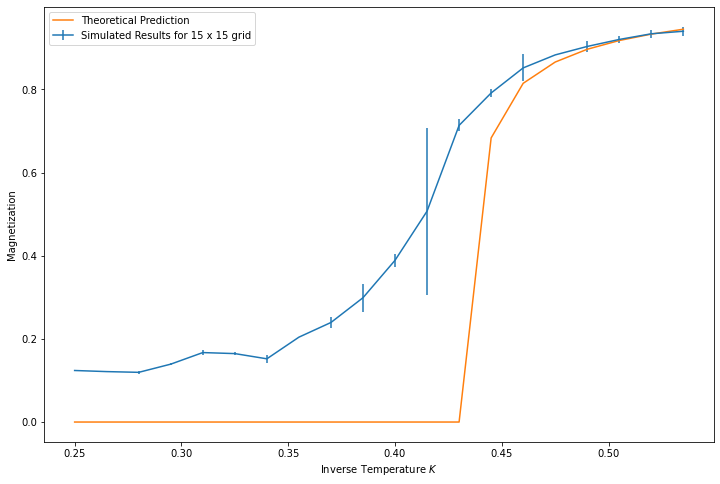

In [139]:
plt.errorbar(K_vals,mags,yerr=stds,label = "Simulated Results for %s x %d grid" %(N,N))

plt.plot(K_vals,(1-np.minimum(1,1/(np.sinh(2*np.array(K_vals)))**4))**(1/8),label='Theoretical Prediction')

plt.xlabel("Inverse Temperature $K$")

plt.ylabel("Magnetization")

plt.legend()

plt.show()

Sadly, this takes a *really* long time to run, so we need a better algorithm.

A big issue is that the Metropolis algorithm does not scale well with large $N\times N$ grids, as it has an intrinsic $O(N^2)$ scaling. We can speed this up by using a _cluster_ algorithm, such as Wolff's algorithm. This algorithm consists of flipping clusters of spins instead of single spins and is considerably faster. Below is the same result as above but with larger grids using Wolff's algorithm.

In [26]:
N_list = [38,44,50,56]
steps = 40
K_low = 0.4
K_high = 0.475
dK = (K_high-K_low)/steps
iters = 10

N_list,K_vals,mags,stds = N_behaviour_wolff(N_list,K_low,dK,steps,iters)

In [28]:
ising_2d = {'N list':N_list,'magnetizations':mags,'deviations':stds,'K_vals':K_vals}

filename = 'N_dependence'
outfile = open(filename,'wb')

pickle.dump(ising_2d,outfile)
outfile.close()

In [30]:
infile = open('N_dependence','rb')
magnetization_values = pickle.load(infile)
infile.close()

magnetizations = magnetization_values['magnetizations']
N_list = magnetization_values['N list']
K_vals = magnetization_values['K_vals']
stds = magnetization_values['deviations']

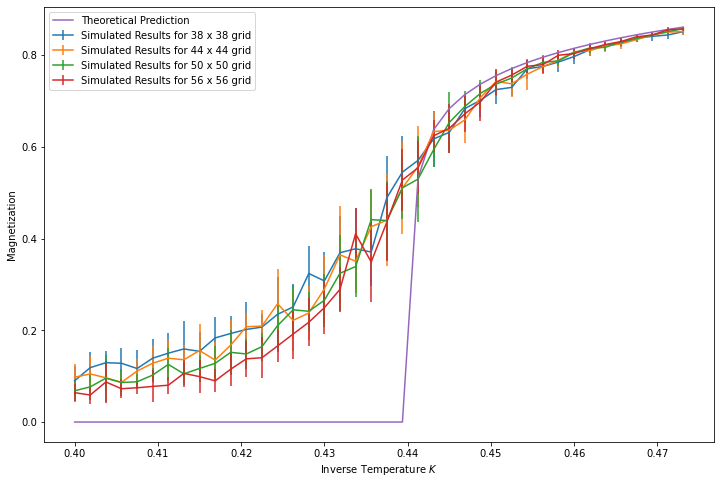

In [31]:
for i in range(len(N_list)):
    plt.errorbar(K_vals[i],magnetizations[i],yerr=stds[i],label = "Simulated Results for %s x %d grid" %(N_list[i],N_list[i]))

plt.plot(K_vals[0],(1-np.minimum(1,1/(np.sinh(2*np.array(K_vals[0])))**4))**(1/8),label='Theoretical Prediction')


plt.xlabel("Inverse Temperature $K$")

plt.ylabel("Magnetization")

plt.legend()

plt.show()

Notably, we do see that with larger $N$ the simulation gets closer to the predicted magnetization curve. Furthermore, it is substantially more efficient using this algorithm.

## In 3 dimensions

Now, let us analyze the same system but in 3 dimensions. Specifically, for the ising model in 3 dimensions we expect a phase transition at $K_c \approx 0.44$. Note that despite the much better algorithm this still takes a long time as there are now $N^3$ spins in the grid.

In [9]:
N = 30
d = 3

M = 1000
dK = 0.005
steps = 40
K_low = 0.18
iters = 5

grid = lattice(d,N)

grid,K_vals,mags,stds = ising3_magnetization(grid,K_low,dK,steps,N,M,iters)

In [123]:
infile = open('ising_3d','rb')
magnetization_values = pickle.load(infile)
infile.close()

magnetizations = magnetization_values['magnetizations']
K_vals = magnetization_values['K values']

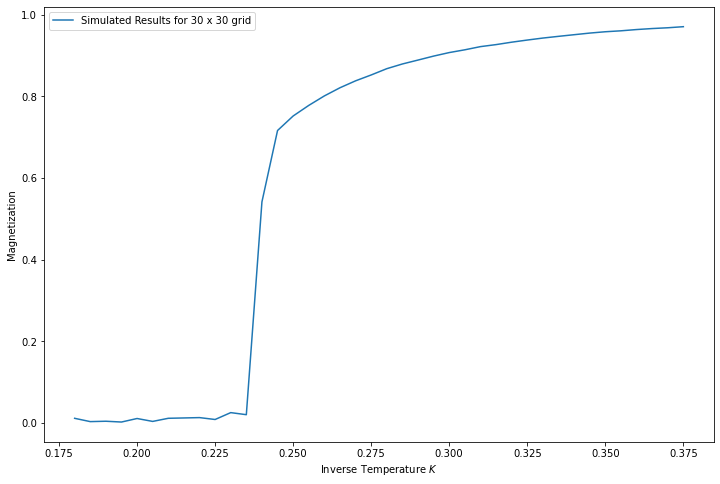

In [124]:
N = 30
plt.errorbar(K_vals,magnetizations,label = "Simulated Results for %s x %d grid" %(N,N))

plt.xlabel("Inverse Temperature $K$")

plt.ylabel("Magnetization")

plt.legend()

plt.show()

Unfortunately for 3-dimensions, the number of spins scales with $N^3$, so it takes a very long time to gather statistics, and I was only able to gather a couple data points with limited range. However, one can indeed see that the system undergoes a transition from disorder to order with $K$ around 0.225, while the correct value is 0.222, so reasonably close.

## Correlation Functions

Now, going back to the 2d ising model, we analyze correlation functions. Specifically, we compute $\langle \sigma_i\sigma_j\rangle$. Notably, these correlation functions at $K = K_C$ vary in a special manner and they decay polynomially as $\langle \sigma_i\sigma_j\rangle \propto \frac{1}{|\mathbf{i}-\mathbf{j}|^{1/4}}$, so we exponent the correlations to decay with a $0.250$ exponent. Let us verify this indeed occurs. However, observe that this is not that simple, as correlation functions at $K\neq K_C$ decay exponentially, and finite size effects make it hard to get this behaviour exactly. To mitigate this, let us try quite a large grid of $100\times 100$.

In [33]:
N = 100

M = 5000
K = 1/2*np.log(1+np.sqrt(2))
iters = 50

grid = lattice(2,N)

correlations,stds = ising2_correlations(grid,K,N,M,iters)

In [125]:
infile = open('correlation_function','rb')
correlation_functions = pickle.load(infile)
infile.close()

correlations = correlation_functions['correlations']
distances = correlation_functions['distances']
deviations = correlation_functions['deviations']

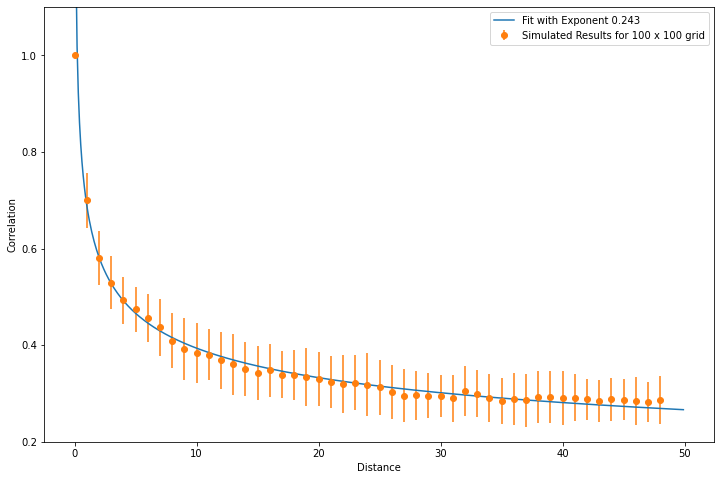

In [126]:
distances = list(range(len(correlations)))
N = 100
def func(x, a, b):
    return a/(x**b)

popt, pcov = curve_fit(func, distances[1:], correlations[1:])

exponent = round(popt[1],3)
error = round(np.sqrt(pcov[1][1]),4)

x_vals = np.arange(0.1,50,0.1)

plt.ylim([0.2,1.1])

plt.plot(x_vals, func(x_vals, *popt),label='Fit with Exponent %s ' %(exponent))

plt.errorbar(distances,correlations,yerr=deviations,label = "Simulated Results for %s x %d grid" %(N,N),fmt='o')

plt.xlabel("Distance")

plt.ylabel("Correlation")

plt.legend()

plt.show()

Interestingly, we see a great polynomial fit with the data, and we find a decay exponent of $0.243\pm 0.003$, which is very close to the true value of $0.250$.

### Potts Model

Now, for fun, let us consider a slight generalization of the Ising model. Specifically, we consider a Potts Hamiltonian $-\beta\mathcal{H} = 2K \sum_{\langle i,j\rangle} \delta_{\sigma_i\sigma_j}$, where each spin $\sigma_i$ can assume one of $q$ values. This system can be reduced to the familiar Ising model, and it also has a phase transition at $K = \frac{1}{2}\ln(1+\sqrt{q})$. Let us analyze the behaviour of this system as a function of $K$ for a system with 4 different spin values $q = 4$.

In [87]:
q = 4
N = 100
M = 10000#This N^2 scaling is apparently needed
K = 0.4

grid = potts_grid(q,N)

grid = potts(grid,K,q,N,M)

<ipython-input-86-76b5f38adbbc>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, grid, cmap='viridis');


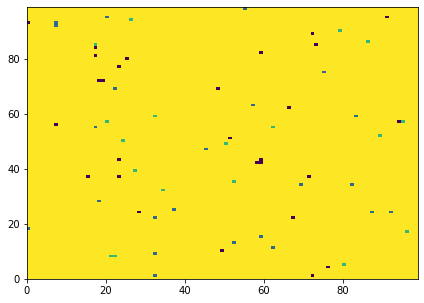

Note the magnetization near 2.5 :3.9852


In [86]:
X, Y = np.meshgrid(range(N), range(N))
plt.pcolormesh(X, Y, grid, cmap='viridis');

plt.show()
print ("Note the magnetization near " + str((q+1)/2) + " :" + str(np.abs(np.mean(grid))))

Notably, one can indeed see that for this $K>>K_C$ the system is ordered, as expected. With this in mind, let us analyze the behaviour of the magnetization as a function of $K$. Unfortunately, the magnetization is something hard to define in this model, so we define an _effective magnetization_, consisting of getting the maximum population of any one of the $q$ spins. Notably, this parameter undergoes a transition, as for $K <<K_C$ we expect all $q$ spins to be equally likely so this effective magnetization will be around $1/q$, whereas for large $K>>K_C$ we expect order, so this effective magnetization will be around $1$. We verify as much below.

In [20]:
N = 30
M = 5000
steps = 80
K_low = 0.2
K_high = 0.4

dK = (K_high-K_low)/steps

iters = 80
Kc = 1/4*np.log(1+np.sqrt(q))


K_vals,mags,stds = potts_magnetization(grid,K_low,dK,steps,q,N,M,iters)

In [33]:
infile = open('potts_model','rb')
magnetization_values = pickle.load(infile)
infile.close()

magnetizations = magnetization_values['magnetizations']
K_vals = magnetization_values['K values']
deviations = magnetization_values['deviations']

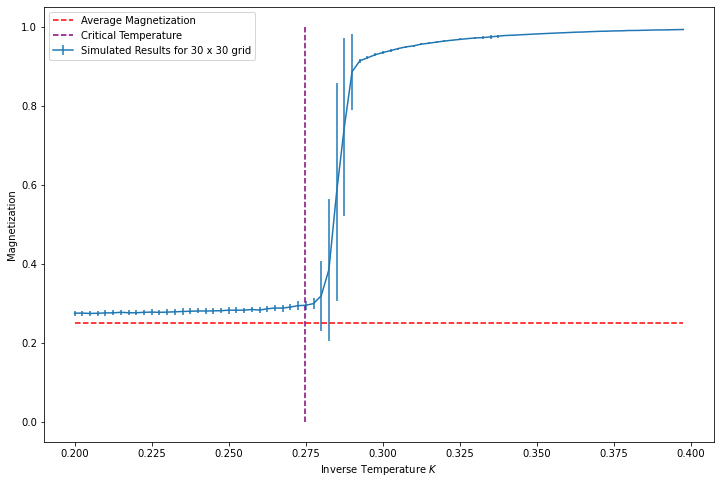

In [35]:
q = 4
N = 30
Kc = 1/4*np.log(1+np.sqrt(q))

plt.errorbar(K_vals,magnetizations,yerr=deviations,label = "Simulated Results for %s x %d grid" %(N,N))

plt.hlines(1/q,K_vals[0],K_vals[-1],linestyle='dashed',label='Average Magnetization',color = 'red')

plt.vlines(Kc,0,1,linestyle='dashed',label='Critical Temperature',color = 'purple')


plt.xlabel("Inverse Temperature $K$")

plt.ylabel("Magnetization")

plt.legend(loc='best')

plt.show()